In [1]:
#Headers for the analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.svm import SVR

In [2]:
#Filler functions
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))#, squared=False)
# Fixed values for the device, not going to change based on our requirement

freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]
freq_dict['bFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000]
# cost_list =['cCost','mCost','gCost']
cFreq = 'bFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'

cost2FMap = {}
cost2FMap['cCost'] = 'bFreq'
cost2FMap['mCost'] = 'mFreq'
cost2FMap['gCost'] = 'gFreq'

## Function to extract the files and send a dataframe

def extractDatafromFile(fileName='./UtilTestFinal',padding=0): ## Generally make the padding 0
    new_data = pd.read_csv(fileName)
    #### This part needs to be 
    if padding == 1:  # if there is not 
        new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = 0
        new_data['gFreq'] = 600000000

    return new_data

#extractDatafromFile()
# Getting the exog list for analysis

def getExog(endog='cCost'):
    cost_list =['cCost','mCost','gCost']
    if endog not in cost_list:
        print("Incorrect Value")
        return None,None
    else:
        my_list = []
        for res in cost_list:
            if res != endog:
                my_list.append(res)
        return my_list[0],my_list[1]

# getExog('gCost')

## Function to shift the data, enabling testing and trainig

def createRequiredDataSet(input_df,endog,shiftAR,shiftARX):
    modified_df = pd.DataFrame()
    ## Get the exog values
    exog,exog1 = getExog(endog)
    modified_df = input_df[[endog,exog,exog1]]
    # Shifting the endog data
    for i in range(1,shiftAR+1):
        modified_df['%s_%d'%(endog,i)] = modified_df[endog].shift(i)

    # Shifting the exog and exog1 data
    modified_df[exog] = modified_df[exog].shift(1)
    modified_df[exog1] = modified_df[exog1].shift(1)

    for i in range(1,shiftARX+1):
        modified_df['%s_%d'%(exog,i)] = modified_df[exog].shift(i+1)
        modified_df['%s_%d'%(exog1,i)] = modified_df[exog1].shift(i+1)

    # Adding the frequency stuff
    modified_df[cFreq] = input_df[cFreq] 
    modified_df[mFreq] = input_df[mFreq] 
    modified_df[gFreq] = input_df[gFreq] 
    modified_df = modified_df.dropna()
    return modified_df


## Test_train divide

def test_train_split(input_df,trainIDX,testIDX,perc=0.8):
    totalLen = len(input_df)
    if trainIDX == -1 or testIDX == -1:
        trainIDX = int(perc*totalLen)
        testIDX = int(perc*totalLen)
    train_df = input_df.iloc[:trainIDX,:]
    test_df = input_df.iloc[testIDX:,:]
    return train_df,test_df


## get the matrices for training, we are assuming that 0 is the y value and the rest are x, we can choose to skip few columns

def getYXData(input_df,ignoreCols=0):
    totalLen = len(input_df.columns)
    y_data = input_df.iloc[:,0].to_numpy()
    x_data = input_df.iloc[:,1:totalLen-ignoreCols].to_numpy()
    return y_data,x_data


def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u


def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result



def simple_test_single(model, xData):
    newX = [1.0]
    newX.extend(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    return y_pred

def getSingleCluster(data, cntr):
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([data]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut


def prediction(model,x,cluster):
    ## get cluster
    N_CLUST = len(model)
    prob_d = getSingleCluster(x,cluster).T[0]
    y = []
    for i in range(N_CLUST):
        ys = simple_test_single(model[i],x)
        y.append(ys*prob_d[i])
    my_pred = min(sum(y)[0],100.0)
    return my_pred


# Prediction of just simple Mean
def prediction_mean(x,hist):
    ## get cluster
    # N_CLUST = len(model)
    # prob_d = getSingleCluster(x,cluster).T[0]
    # y = []
    # for i in range(N_CLUST):
    #     ys = simple_test_single(model[i],x)
    #     y.append(ys*prob_d[i])
    my_pred = np.mean(x[:hist])
    return my_pred

In [3]:
def getPredF(est_util, act_util, freq_list):
    eff_u = -1
    max_f = max(freq_list)
    est_freq = max_f
    for f in freq_list:
        eff_u = est_util * max_f/f
        if eff_u <=100 or f == max_f:
            eff_y = act_util * max_f/f
            return f,eff_u,eff_y
    return max_f,-1,-1
def energy_perf_analysis(y_act,y_est,act_freq,endog, details=False):
    eff_util = []
    est_freq = []
    possible_freq_config = freq_dict[cost2FMap[endog]] ## list of all possible frequency in increasing order
    LEN = len(y_act)
    energy_save = 0.
    for idx in range(LEN):
        pred_f, eff_u, eff_y = getPredF(y_est[idx],y_act[idx],possible_freq_config)
        eff_util.append(eff_y)
        est_freq.append(pred_f)
        # print(pred_f, act_freq[idx])
        energy_save += math.ceil(eff_y/100.) * (pred_f/act_freq[idx])**2
        
        
    stall = (sum( i > 100 for i in eff_util ) * 100) / LEN
    energy_ratio = 1.0 - (energy_save/LEN)
    if details:
        return stall, energy_ratio, est_freq, eff_util
    return stall, energy_ratio

    
        
    
    
    

In [4]:
##n imports

from numpy import array
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Input

## Lets do univariate models


def getUnivariateDataSplit(listData, shiftAR=8): # This will create a new df so that we can run the LSTM
    modified_df = pd.DataFrame()
    modified_df['endog'] = listData
    for i in range(1,shiftAR+1):
        modified_df['endog_%d'%(i)] = modified_df['endog'].shift(i)
        
    modified_df = modified_df.dropna()
    return modified_df
    

    


# def LSTM(x_train,y_train,x_test,y_test):
#     pass



2024-07-17 12:24:28.107459: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 12:24:28.128133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 12:24:28.128150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 12:24:28.128164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 12:24:28.132195: I tensorflow/core/platform/cpu_feature_g

In [9]:
my_test = extractDatafromFile('./UtilTestFinal',1)
MyData = getUnivariateDataSplit(my_test['cCost'].to_numpy(), shiftAR=8)
train_df,test_df = test_train_split(MyData,trainIDX=5000,testIDX=5000,perc=0.0)
y_train,x_train = getYXData(train_df)
y_test,x_test = getYXData(test_df)
#Reshape the data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
#LSTM 
n_steps = x_train.shape[1]
n_features = 1
# define model
model = Sequential()
model.add(LSTM(50, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=25, verbose=0)

In [10]:
x_test_T = x_test[:2000]
x_test_r = x_test_T.reshape(2000,n_steps,1)
yhat = model.predict(x_test_r, verbose=0)
# yhat
# yhat = np.array(yhat)
yOut = yhat.reshape(-1)
# yOut
rmse(yOut,y_test[:2000])

6.0440663690707

In [ ]:
## A different LSTM modeling ... with Conv Neural Network 

# Steps -- try to get the pipeline running....






In [5]:
## LSTM Modeling....

my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='mCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)


## This might not be the best data respresentation, but we will get into it if requried.

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)

SVR()

In [6]:
my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='cCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)
    

SVR()

In [7]:
svr_rbf.predict(X_test_scaled_T)

array([98.21208256, 98.21208256, 97.71160807, 97.22031932, 96.29375703,
       96.75733741, 96.41729684, 97.15077651, 97.1614227 , 97.98618067,
       98.48208049, 98.96255794, 98.21208256, 98.21208256, 97.71160807,
       96.75293238, 96.29375703, 95.95599925, 95.62413956, 96.48436685,
       96.48436685, 97.31229197, 98.14545513, 98.96255794, 98.21208256,
       98.21208256, 97.71160807, 96.75293238, 96.29375703, 96.41729684,
       96.80954054, 96.82374264, 97.65378071, 98.48208049, 98.96255794,
       97.73799984, 97.73799984, 97.364991  , 96.53923495, 95.63920018,
       96.82912565, 96.81479848, 97.42856454, 97.7161715 , 98.53731825,
       98.7547116 , 97.73799984, 98.21208256, 97.364991  , 96.41460018,
       95.97089408, 96.41729684, 96.08312039, 96.09790057, 97.1614227 ,
       97.49102016, 97.98618067, 97.73793   , 98.21208256, 97.71160807,
       96.75293238, 96.29375703, 96.41729684, 96.08312039, 96.82374264,
       97.1614227 , 97.98618067, 98.48208049, 98.96255794, 97.73

In [8]:
y_test[:TEST_LEN]

array([100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  ,   0.75,   1.8 ,   2.4 ,   4.25,   2.4 ,   2.4 ,
         4.5 ,   1.2 ,   2.  ,   2.  ,   4.25,   1.8 ,   3.5 ,   2.  ,
         2.  ,   2.2 ,   2.6 ,   2.4 ,   1.8 ,   1.8 ,   2.7 ,   7.5 ,
         2.4 ,   4.5 ,   2.  ,   2.  ,   4.25,   2.  ,   2.  ,   2.6 ,
         4.5 ,   1.8 ,   4.75,   2.  ,   4.25,   1.8 ,   1.8 ,   6.6 ,
      

# Pipelined Approach 

In [9]:
def ModelPipeline_LSTM(fileName,padding=0,endog='cCost',Kernel='rbf',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    pass

In [43]:
def ModelPipeline_SVR(fileName,padding=0,endog='cCost',Kernel='rbf',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 1 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    scaler = StandardScaler().fit(x_train)
    X_train_scaled = scaler.transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    svr = SVR(kernel = Kernel)
    svr.fit(X_train_scaled, y_train)
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    X_test_scaled_T = X_test_scaled[:TEST_LEN]
    ys_est = svr.predict(X_test_scaled_T)
    # ys_est = []
    # for id in range(TEST_LEN):
    #     predVal = prediction(model,x_test[id],cluster_center)
    #     ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [44]:
def ModelPipeline_Mean(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    # ### Train the Model
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction_mean(x_test[id],shiftAR)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [45]:
def ModelPipeline(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    model = []
    for i in range(N_CLUST):
        out_model = simple_train(y_train,x_train,weight = prob[i,:])
        model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction(model,x_test[id],cluster_center)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [46]:
y_est,y_act,err,est_freq, act_freq,eff_util,stall,energy = ModelPipeline('./UtilTestFinal',padding=1,\
                                                                         endog='gCost',N_CLUST=3,shiftAR=10,shiftARX=3,\
                                                                         trainIDX=5000,testIDX=5000,TEST_LEN = 200)

In [47]:
stall

0.0

In [48]:
## 
test_endog = 'cCost'
TrIDX = 5000
TIDX = 5000
TLEN = 2000

In [49]:
my_data = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline('./UtilTestFinal',padding=1,\
                                                                            endog=test_endog,N_CLUST=2,shiftAR=val,shiftARX=val-5,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    data = (val,rms,stall,energy)
    my_data.append(data)
    

#AR  2  RMSE : 7.52964598696477
#AR  3  RMSE : 6.640720781708288
#AR  4  RMSE : 6.232028891118944
#AR  5  RMSE : 5.818915262455695
#AR  6  RMSE : 4.910070672315444
#AR  7  RMSE : 4.55114491541928
#AR  8  RMSE : 4.190209042679231
#AR  9  RMSE : 3.9129357380556384
#AR  10  RMSE : 3.8418697559683763
#AR  11  RMSE : 3.833617341073307
#AR  12  RMSE : 3.881406197165761
#AR  13  RMSE : 3.7985961221324986
#AR  14  RMSE : 3.781219305082141
#AR  15  RMSE : 3.7597380923013235


In [50]:
my_data_mean = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_Mean('./UtilTestFinal',padding=1,\
                                                                            endog=test_endog,N_CLUST=5,shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    data = (val,rms,stall,energy)
    my_data_mean.append(data)

#AR  2  RMSE : 46.34908452461819
#AR  3  RMSE : 31.013742453005623
#AR  4  RMSE : 23.408986168395543
#AR  5  RMSE : 18.899209736121215
#AR  6  RMSE : 15.938318559333942
#AR  7  RMSE : 13.86798699270981
#AR  8  RMSE : 12.364081670062172
#AR  9  RMSE : 11.236442410356856
#AR  10  RMSE : 10.37795158234775
#AR  11  RMSE : 9.713002096583613
#AR  12  RMSE : 9.192247352107884
#AR  13  RMSE : 8.78383929295734
#AR  14  RMSE : 8.46611697501485
#AR  15  RMSE : 8.221453601365317


In [51]:
my_data_svr = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_SVR('./UtilTestFinal',padding=1,\
                                                                            endog=test_endog,Kernel='rbf',N_CLUST=0,\
                                                                            shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("SVR: #AR ",val," RMSE :", rms)
    data = (val,rms,stall,energy)
    my_data_svr.append(data)

SVR: #AR  2  RMSE : 44.981948332919124
SVR: #AR  3  RMSE : 45.1195915892379
SVR: #AR  4  RMSE : 45.071263454952685
SVR: #AR  5  RMSE : 45.366616573086574
SVR: #AR  6  RMSE : 45.51016583129201
SVR: #AR  7  RMSE : 45.999216822081394
SVR: #AR  8  RMSE : 46.36674515323461
SVR: #AR  9  RMSE : 46.554991346499705
SVR: #AR  10  RMSE : 46.896423909353786
SVR: #AR  11  RMSE : 47.262897220295365
SVR: #AR  12  RMSE : 47.67572685089981
SVR: #AR  13  RMSE : 47.99020667174805
SVR: #AR  14  RMSE : 48.15760589436272
SVR: #AR  15  RMSE : 48.41013666019525


In [19]:
x = list(map(lambda x: x[0], my_data))
y = list(map(lambda x: x[3], my_data))
y_svr = list(map(lambda x: x[1], my_data_svr))
y_mean = list(map(lambda x: x[1], my_data_mean))

In [86]:
# ##Combined Plot
# plt.plot(x, y, label='Our Method') 
# # plt.plot(x, y_svr, label='SVR') 
# # plt.plot(x, y_mean, label='Mean') 

# plt.xlabel("AR") 
# plt.ylabel("Energy") 
# plt.title("Comparing Model") 
# plt.legend() 
# plt.show() 

## Mem Values

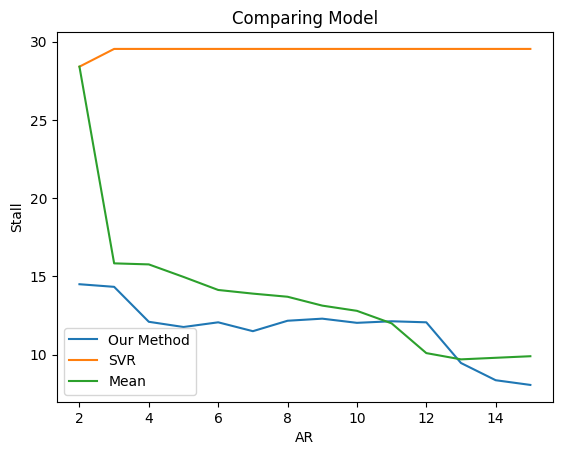

In [69]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

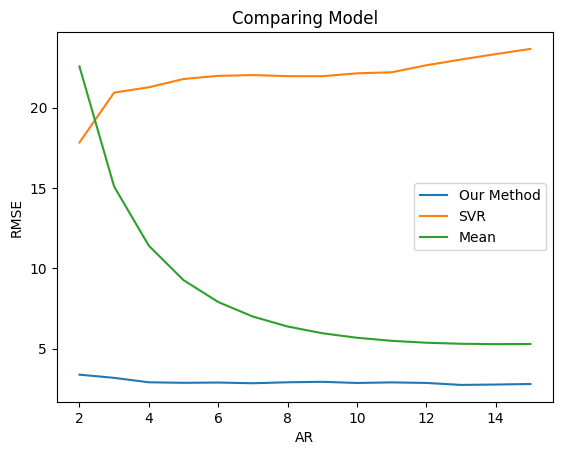

In [67]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

## CPU Values

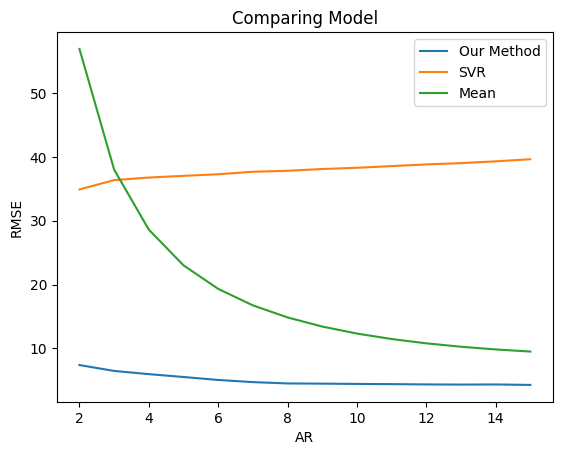

In [78]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show()

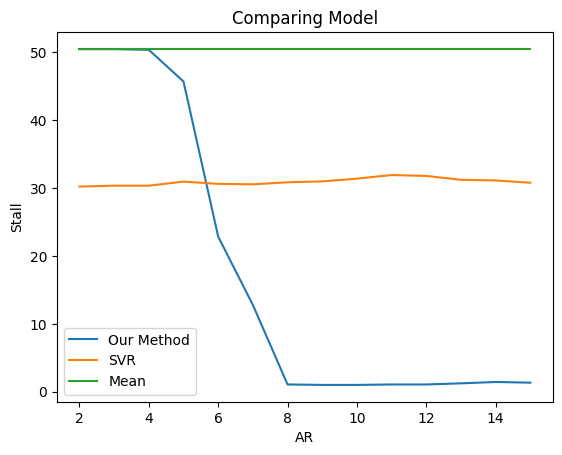

In [59]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

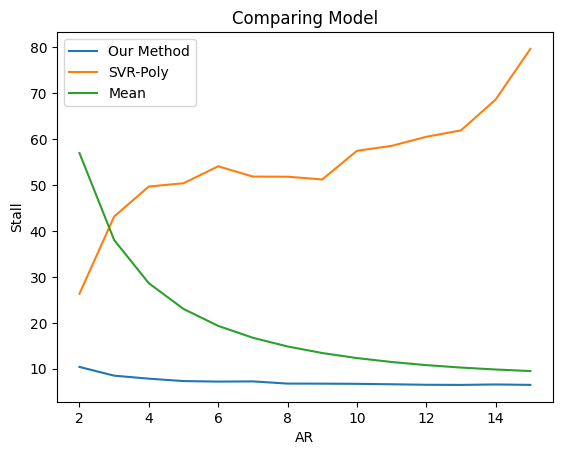

In [39]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR-Poly') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

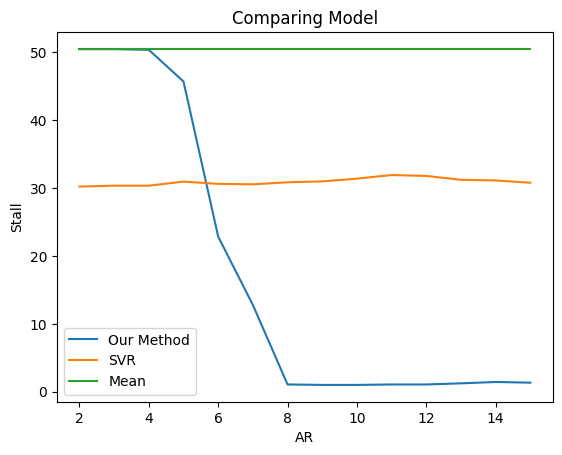

In [58]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 